In [1]:

hex_ids = ["0x0239", "0x040B", "0x0575", "0x0643", "0x0760", "0x09AF", "0x0F42", "0x1048",
           "0x10C9", "0x1284", "0x1714", "0x1858", "0x1AC6", "0x22C6", "0x23A7", "0x240F",
           "0x2A38", "0x2A56", "0x2FC7", "0x3060", "0x35C3", "0x3812", "0x3B68", "0x409B",
           "0x41B2", "0x429B", "0x4724", "0x48C1", "0x4A32", "0x4BF8", "0x53AF", "0x53D7",
           "0x5B30", "0x5DA9", "0x5F01", "0x616A", "0x850E", "0x8F63", "0x93AC",
           "0x9591", "0x96F7", "0x9BF5", "0xA2DA", "0xA7B2", "0xA960", "0xB744", "0xB8AD",
           "0xBC16", "0xBCA3", "0xBDF1", "0xBF36", "0xC248", "0xC4B2", "0xC766", "0xCBD6",
           "0xCE97", "0xD326", "0xDA80", "0xE605", "0xF43F", "0xF5A4"]



In [ ]:
#These have more difficult solutions
'''
hex_ids = ["0x0239", "0x040B", "0x0643", "0x0760", "0x09AF", "0x0F42", "0x1048",
           "0x1284", "0x1714", "0x1AC6", "0x22C6", "0x240F",
           "0x2A38", "0x2A56", "0x2FC7", "0x3060", "0x35C3", "0x3812", "0x3B68", "0x409B",
           "0x41B2", "0x4724", "0x4BF8", "0x53AF", "0x53D7",
           "0x5DA9", "0x616A", "0x93AC",
           "0x9591", "0x96F7", "0x9BF5", "0xA960", "0xB744", "0xB8AD",
           "0xBC16", "0xBCA3", "0xBDF1", "0xC248", "0xC4B2", "0xC766", "0xCBD6",
           "0xCE97", "0xD326", "0xDA80", "0xE605", "0xF43F", "0xF5A4"]
'''

In [2]:
len(hex_ids)

61

Trained for scratch (new) vs fine-tune (50,000 steps)

[Fine-tune vs Scratch] counts: {'Win': 8, 'Loss': 1, 'Tie': 52} out of N=61 (missing 0)
  Wins  (8): 0x0F42, 0x1048, 0x10C9, 0x4A32, 0xA2DA, 0xB8AD, 0xC4B2, 0xDA80
  Losses(1): 0xBC16
  Ties  (52): 0x0239, 0x040B, 0x0575, 0x0643, 0x0760, 0x09AF, 0x1284, 0x1714, 0x1858, 0x1AC6, 0x22C6, 0x23A7, 0x240F, 0x2A38, 0x2A56, 0x2FC7, 0x3060, 0x35C3, 0x3812, 0x3B68, 0x409B, 0x41B2, 0x429B, 0x4724, 0x48C1, 0x4BF8, 0x53AF, 0x53D7, 0x5B30, 0x5DA9, 0x5F01, 0x616A, 0x850E, 0x8F63, 0x93AC, 0x9591, 0x96F7, 0x9BF5, 0xA7B2, 0xA960, 0xB744, 0xBCA3, 0xBDF1, 0xBF36, 0xC248, 0xC766, 0xCBD6, 0xCE97, 0xD326, 0xE605, 0xF43F, 0xF5A4


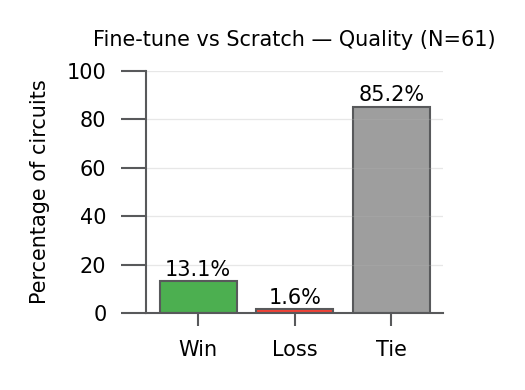

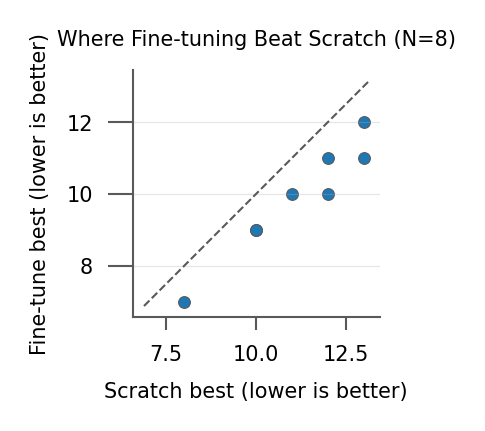

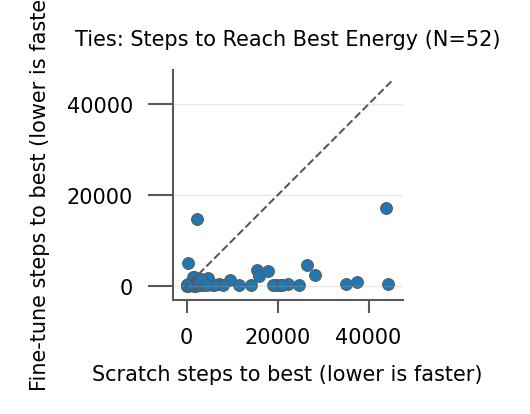

In [9]:
# Fine-tuning (TensorBoard) vs SCRATCH (TensorBoard)
# - Prints per-circuit Wins/Losses/Ties by hex_id

from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
from typing import Dict, List, Tuple, Optional

# ----------------
mpl.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 5, "axes.titlesize": 5, "axes.labelsize": 5,
    "legend.fontsize": 5, "xtick.labelsize": 5, "ytick.labelsize": 5,
    "pdf.fonttype": 42, "ps.fonttype": 42,
    "pdf.use14corefonts": False, "svg.fonttype": "none",
    "axes.linewidth": 0.5, "lines.linewidth": 0.5,
    "legend.frameon": False,
    "savefig.dpi": 300, "figure.dpi": 100,
})
EDGE_COL, EDGE_W = "#58595B", 0.5
pt_to_in = lambda pt: pt / 72.0

def _style_axes(ax, grid_y=True):
    # ticks
    ax.tick_params(axis="y", which="major", width=EDGE_W, length=6, color=EDGE_COL)
    ax.tick_params(axis="y", which="minor", width=EDGE_W, length=3, color=EDGE_COL)
    ax.tick_params(axis="x", which="both",  width=EDGE_W, length=3, color=EDGE_COL)
    # spines
    for s in ["left", "bottom"]:
        ax.spines[s].set_linewidth(EDGE_W)
        ax.spines[s].set_color(EDGE_COL)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    # grid
    if grid_y:
        ax.grid(True, axis="y", which="major", linewidth=0.3, alpha=0.3)

SCRATCH_ROOT_TEMPLATE = (
    "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/"
    "manuscript/scratch_training/4in/{HEX}/seed_1"
)

FINETUNE_ROOT_TEMPLATE = (
    "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/"
    "manuscript/fine_tune/GAT_MLP_with_scalars/4000nn/initial_state_sampling_factor_0/"
    "4_inputs/50_000_steps/{HEX}/seed_1"
)

EVENT_GLOBS = ["**/events.out.tfevents.*", "**/*tfevents*"]
TB_TAG = "custom/best_energy"
ASSUME_TAG_IS_BEST = True  # if True, use final point; else use global min over series

def _norm_hex(x: str) -> str:
    s = str(x).strip().lower()
    if not s.startswith("0x"):
        s = "0x" + s
    return "0x" + s[2:].upper()

def scratch_root_for_hex(hex_id: str) -> Path:
    return Path(SCRATCH_ROOT_TEMPLATE.format(HEX=_norm_hex(hex_id)))

def finetune_root_for_hex(hex_id: str) -> Path:
    return Path(FINETUNE_ROOT_TEMPLATE.format(HEX=_norm_hex(hex_id)))

def find_event_files(root: Path) -> List[Path]:
    files = []
    for pat in EVENT_GLOBS:
        files.extend(root.glob(pat))
    return sorted(set(files), key=lambda p: p.as_posix())

def load_tb_scalar_from_dir(run_dir: Path, tag: str) -> Tuple[np.ndarray, np.ndarray]:
    try:
        ea = event_accumulator.EventAccumulator(str(run_dir))
        ea.Reload()
        if tag not in ea.Tags().get("scalars", []):
            return np.array([], dtype=int), np.array([], dtype=float)
        events = ea.Scalars(tag)
        steps  = np.fromiter((e.step  for e in events), dtype=int)
        values = np.fromiter((e.value for e in events), dtype=float)
        return steps, values
    except Exception as e:
        print(f"[WARN] TB load failed in {run_dir}: {e}")
        return np.array([], dtype=int), np.array([], dtype=float)

def pick_best_from_runs(run_dirs: List[Path], tag: str, assume_best_series=True) -> Tuple[Optional[float], Optional[Path], np.ndarray, np.ndarray]:
    """Return (best_value, chosen_dir, steps, values) for the best run (lowest value)."""
    best_val, best_dir, best_steps, best_values = None, None, None, None
    for d in run_dirs:
        steps, vals = load_tb_scalar_from_dir(d, tag)
        if steps.size == 0:
            continue
        final = float(vals[-1]) if assume_best_series else float(np.nanmin(vals))
        if best_val is None or final < best_val:
            best_val, best_dir, best_steps, best_values = final, d, steps, vals
    return best_val, best_dir, best_steps, best_values

def _steps_to_global_min(steps: Optional[np.ndarray], vals: Optional[np.ndarray]) -> float:
    """Return the step index where the (first) global minimum is reached, or NaN."""
    if steps is None or vals is None or len(steps) == 0 or len(vals) == 0:
        return float("nan")
    idx = int(np.nanargmin(vals))
    return float(steps[idx])


def compare_finetune_to_scratch_tb(
    hex_ids: List[str],
    tag: str = TB_TAG,
    assume_tag_is_best: bool = ASSUME_TAG_IS_BEST,
    make_plot: bool = True,
    show_plot: bool = True,
    save_plot_path: Optional[Path] = None,
    save_summary_csv: Optional[Path] = None,
    per_hex_plot_dir: Optional[Path] = None,
    # Existing NEW:
    make_win_comparison_plot: bool = True,
    save_win_comparison_plot_path: Optional[Path] = None,
    # NEW (this request):
    make_tie_steps_plot: bool = True,
    save_tie_steps_plot_path: Optional[Path] = None,
):
    outcomes = {"Win": 0, "Loss": 0, "Tie": 0}
    rows = []
    missing = []

    # Track exactly which circuits fall into each bucket
    win_hex, loss_hex, tie_hex = [], [], []

    for hex_id in hex_ids:
        hex_norm = _norm_hex(hex_id)

        # FINETUNE
        ft_root = finetune_root_for_hex(hex_norm)
        ft_events = find_event_files(ft_root)
        ft_run_dirs = sorted(set(p.parent for p in ft_events))
        ft_best, ft_dir, ft_steps, ft_vals = pick_best_from_runs(ft_run_dirs, tag, assume_tag_is_best)

        # SCRATCH
        sc_root = scratch_root_for_hex(hex_norm)
        sc_events = find_event_files(sc_root)
        sc_run_dirs = sorted(set(p.parent for p in sc_events))
        sc_best, sc_dir, sc_steps, sc_vals = pick_best_from_runs(sc_run_dirs, tag, assume_tag_is_best)

        if ft_best is None or sc_best is None:
            missing.append(hex_norm)
            continue

        if ft_best < sc_best:
            outcomes["Win"] += 1; verdict = "Win";  win_hex.append(hex_norm)
        elif ft_best > sc_best:
            outcomes["Loss"] += 1; verdict = "Loss"; loss_hex.append(hex_norm)
        else:
            outcomes["Tie"] += 1; verdict = "Tie";  tie_hex.append(hex_norm)

        # Steps to *global min* (when the best energy was first achieved)
        ft_steps_to_best = _steps_to_global_min(ft_steps, ft_vals)
        sc_steps_to_best = _steps_to_global_min(sc_steps, sc_vals)

        rows.append({
            "hex_id": hex_norm,
            "finetune_best": float(ft_best),
            "scratch_best": float(sc_best),
            "delta_finetune_minus_scratch": float(ft_best - sc_best),
            "result": verdict,
            "finetune_chosen_run_dir": str(ft_dir) if ft_dir else "",
            "scratch_chosen_run_dir": str(sc_dir) if sc_dir else "",
            # NEW columns for downstream analysis and the tie-steps plot
            "finetune_steps_to_best": ft_steps_to_best,
            "scratch_steps_to_best": sc_steps_to_best,
        })

        # Optional per-hex plot of both series (kept simple; export style mainly for summary figs)
        if per_hex_plot_dir is not None and ft_steps is not None and ft_vals is not None:
            per_hex_plot_dir = Path(per_hex_plot_dir)
            per_hex_plot_dir.mkdir(parents=True, exist_ok=True)
            fig_hex, ax = plt.subplots(figsize=(pt_to_in(230), pt_to_in(170)), dpi=300)
            if sc_steps is not None and sc_vals is not None and len(sc_steps) > 0:
                ax.plot(sc_steps, sc_vals, lw=1.0, label="scratch")
                ax.axhline(y=float(sc_best), color=EDGE_COL, ls="--", lw=EDGE_W, label="scratch best")
            ax.plot(ft_steps, ft_vals, lw=1.0, label="finetune")
            ax.axhline(y=float(ft_best), color=EDGE_COL, ls=":", lw=EDGE_W, label="finetune best")
            ax.set_xlabel("Training steps")
            ax.set_ylabel("Metric (lower is better)")
            ax.set_title(f"{hex_norm}  (FT={ft_best:.3g}, SC={sc_best:.3g})")
            ax.legend(frameon=False)
            _style_axes(ax, grid_y=True)
            fig_hex.tight_layout()
            fig_hex.savefig(per_hex_plot_dir / f"{hex_norm}.png", bbox_inches="tight")
            plt.close(fig_hex)

    n_used = len(rows)
    print(f"[Fine-tune vs Scratch] counts: {outcomes} out of N={n_used} (missing {len(missing)})")
    if win_hex:
        print(f"  Wins  ({len(win_hex)}): {', '.join(sorted(win_hex))}")
    if loss_hex:
        print(f"  Losses({len(loss_hex)}): {', '.join(sorted(loss_hex))}")
    if tie_hex:
        print(f"  Ties  ({len(tie_hex)}): {', '.join(sorted(tie_hex))}")
    if missing:
        print(f"  Missing ({len(missing)}): {', '.join(sorted(missing))}")

    per_hex = pd.DataFrame(rows)
    if n_used == 0:
        win_pct = loss_pct = tie_pct = 0.0
    else:
        win_pct  = 100.0 * outcomes["Win"]  / n_used
        loss_pct = 100.0 * outcomes["Loss"] / n_used
        tie_pct  = 100.0 * outcomes["Tie"]  / n_used

    summary = pd.DataFrame([{
        "N_used": n_used,
        "Win": outcomes["Win"], "Loss": outcomes["Loss"], "Tie": outcomes["Tie"],
        "Win_%": win_pct, "Loss_%": loss_pct, "Tie_%": tie_pct,
        "N_missing": len(missing),
        "Missing_hex_ids": ",".join(sorted(missing)),
        "Wins_hex_ids": ",".join(sorted(win_hex)),
        "Losses_hex_ids": ",".join(sorted(loss_hex)),
        "Ties_hex_ids": ",".join(sorted(tie_hex)),
        "tag": tag,
        "assume_tag_is_best": assume_tag_is_best,
    }])

    # --- Figure 1: overall Win/Loss/Tie percentages (styled) ---
    fig = None
    if make_plot:
        cats = ["Win", "Loss", "Tie"]
        vals = [win_pct, loss_pct, tie_pct]
        fig, ax = plt.subplots(figsize=(pt_to_in(110), pt_to_in(90)), dpi=300)
        bars = ax.bar(cats, vals,
                      color=["#4CAF50", "#F44336", "#9E9E9E"],
                      edgecolor=EDGE_COL, linewidth=EDGE_W)
        ax.set_ylim(0, 100)
        ax.set_ylabel("Percentage of circuits")
        ax.set_title(f"Fine-tune vs Scratch — Quality (N={n_used})")
        for i, v in enumerate(vals):
            ax.text(i, min(100, v) + 0.5, f"{v:.1f}%", ha="center", va="bottom")
        _style_axes(ax, grid_y=True)
        fig.tight_layout()
        if save_plot_path is not None:
            save_plot_path = Path(save_plot_path)
            save_plot_path.parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(save_plot_path, bbox_inches="tight")
        if show_plot:
            plt.show()

    # --- Figure 2: comparison among wins only (styled) ---
    fig_win = None
    if make_win_comparison_plot:
        wins_only = per_hex[per_hex["result"] == "Win"].copy()
        if len(wins_only) > 0:
            fig_win, ax2 = plt.subplots(figsize=(pt_to_in(100), pt_to_in(100)), dpi=300)
            x_sc = wins_only["scratch_best"].to_numpy(dtype=float)
            y_ft = wins_only["finetune_best"].to_numpy(dtype=float)
            ax2.scatter(x_sc, y_ft, s=8, edgecolors=EDGE_COL, linewidths=EDGE_W/2)
            lo = float(min(np.nanmin(x_sc), np.nanmin(y_ft)))
            hi = float(max(np.nanmax(x_sc), np.nanmax(y_ft)))
            pad = 0.02 * (hi - lo) if hi > lo else 1.0
            ax2.plot([lo - pad, hi + pad], [lo - pad, hi + pad], "--", lw=EDGE_W, color=EDGE_COL)
            ax2.set_xlabel("Scratch best (lower is better)")
            ax2.set_ylabel("Fine-tune best (lower is better)")
            ax2.set_title(f"Where Fine-tuning Beat Scratch (N={len(wins_only)})")
            ax2.set_aspect("equal", adjustable="box")
            _style_axes(ax2, grid_y=True)
            fig_win.tight_layout()
            if save_win_comparison_plot_path is not None:
                save_win_comparison_plot_path = Path(save_win_comparison_plot_path)
                save_win_comparison_plot_path.parent.mkdir(parents=True, exist_ok=True)
                fig_win.savefig(save_win_comparison_plot_path, bbox_inches="tight")
            if show_plot:
                plt.show()
        else:
            print("[Info] No winning circuits; skipping win-comparison plot.")

    # --- Figure 3 (NEW): Ties — steps to reach best energy (styled) ---
    fig_tie_steps = None
    if make_tie_steps_plot:
        ties_only = per_hex[per_hex["result"] == "Tie"].copy()
        ties_only = ties_only.dropna(subset=["scratch_steps_to_best", "finetune_steps_to_best"])
        if len(ties_only) > 0:
            fig_tie_steps, ax3 = plt.subplots(figsize=(pt_to_in(100), pt_to_in(100)), dpi=300)
            x_sc = ties_only["scratch_steps_to_best"].astype(float).to_numpy()
            y_ft = ties_only["finetune_steps_to_best"].astype(float).to_numpy()
            ax3.scatter(x_sc, y_ft, s=8, edgecolors=EDGE_COL, linewidths=EDGE_W/2)
            lo = float(min(np.nanmin(x_sc), np.nanmin(y_ft)))
            hi = float(max(np.nanmax(x_sc), np.nanmax(y_ft)))
            pad = 0.02 * (hi - lo) if hi > lo else 1.0
            ax3.plot([lo - pad, hi + pad], [lo - pad, hi + pad], "--", lw=EDGE_W, color=EDGE_COL)
            ax3.set_xlabel("Scratch steps to best (lower is faster)")
            ax3.set_ylabel("Fine-tune steps to best (lower is faster)")
            ax3.set_title(f"Ties: Steps to Reach Best Energy (N={len(ties_only)})")
            ax3.set_aspect("equal", adjustable="box")
            _style_axes(ax3, grid_y=True)
            fig_tie_steps.tight_layout()
            if save_tie_steps_plot_path is not None:
                save_tie_steps_plot_path = Path(save_tie_steps_plot_path)
                save_tie_steps_plot_path.parent.mkdir(parents=True, exist_ok=True)
                fig_tie_steps.savefig(save_tie_steps_plot_path, bbox_inches="tight")
            if show_plot:
                plt.show()
        else:
            print("[Info] No ties; skipping tie-steps plot.")

    if save_summary_csv is not None:
        save_summary_csv = Path(save_summary_csv)
        save_summary_csv.parent.mkdir(parents=True, exist_ok=True)
        summary.to_csv(save_summary_csv, index=False)
        per_hex_path = save_summary_csv.with_name(save_summary_csv.stem + "_per_hex.csv")
        per_hex.to_csv(per_hex_path, index=False)

    # Return all figures
    return summary, per_hex, fig, fig_win, fig_tie_steps



# ---- Example call ----
summary_df, per_hex_df, fig, fig_win, fig_tie_steps = compare_finetune_to_scratch_tb(
    hex_ids=hex_ids,                  # list of "0x.." ids
    tag="custom/best_energy",
    assume_tag_is_best=True,          # True: use final; False: global min
    make_plot=True,
    show_plot=True,
    make_win_comparison_plot=True,
    # save_plot_path=Path("./finetune_vs_scratch.png"),
    # save_win_comparison_plot_path=Path("./finetune_wins_scatter.png"),
    # save_summary_csv=Path("./finetune_vs_scratch_summary.csv"),
    # per_hex_plot_dir=Path("./per_hex_plots"),
)



[Fine-tune vs Scratch] counts: {'Win': 8, 'Loss': 1, 'Tie': 52} out of N=61 (missing 0)
  Wins  (8): 0x0F42, 0x1048, 0x10C9, 0x4A32, 0xA2DA, 0xB8AD, 0xC4B2, 0xDA80
  Losses(1): 0xBC16
  Ties  (52): 0x0239, 0x040B, 0x0575, 0x0643, 0x0760, 0x09AF, 0x1284, 0x1714, 0x1858, 0x1AC6, 0x22C6, 0x23A7, 0x240F, 0x2A38, 0x2A56, 0x2FC7, 0x3060, 0x35C3, 0x3812, 0x3B68, 0x409B, 0x41B2, 0x429B, 0x4724, 0x48C1, 0x4BF8, 0x53AF, 0x53D7, 0x5B30, 0x5DA9, 0x5F01, 0x616A, 0x850E, 0x8F63, 0x93AC, 0x9591, 0x96F7, 0x9BF5, 0xA7B2, 0xA960, 0xB744, 0xBCA3, 0xBDF1, 0xBF36, 0xC248, 0xC766, 0xCBD6, 0xCE97, 0xD326, 0xE605, 0xF43F, 0xF5A4


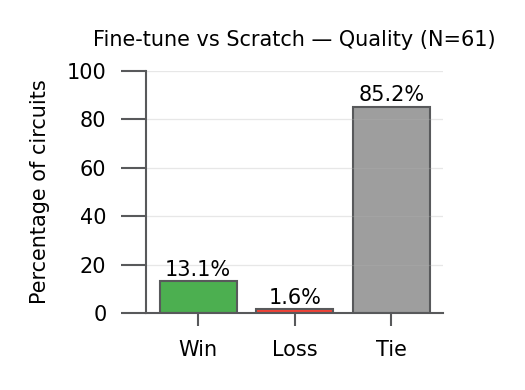

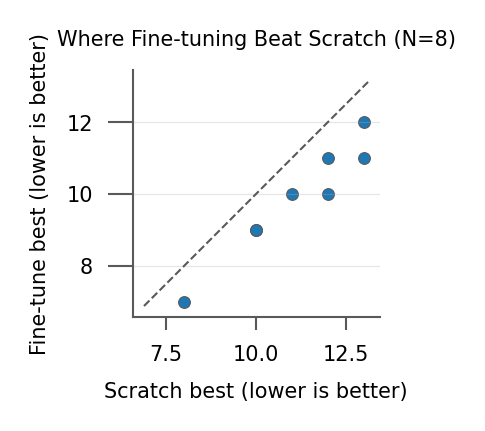

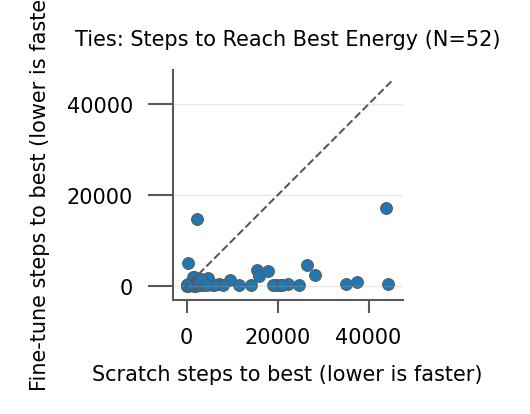

In [10]:
folder = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/plots/finetune_vs_scratch_50000_quality_sf0"
base = Path(folder)  # turn the string into a Path

summary_df, per_hex_df, fig, fig_win, fig_tie_steps = compare_finetune_to_scratch_tb(
    hex_ids=hex_ids,                  # list of "0x.." ids
    tag="custom/best_energy",
    assume_tag_is_best=True,          # True: use final; False: global min
    make_plot=True,
    show_plot=True,
    make_win_comparison_plot=True,
    save_plot_path= base / "finetune_vs_scratch.svg",
    save_win_comparison_plot_path= base / "finetune_wins_scatter.svg",
    save_tie_steps_plot_path = base / "tied_quality_steps_to_best_solution.svg",
    save_summary_csv = base / "finetune_vs_scratch_summary.csv",
    per_hex_plot_dir=Path(base / "per_hex_plots"),
)

Zero-shot (51,400) versus fine-tune (51,400)

[Trained vs Fine-tuning] counts: {'Win': 4, 'Loss': 1, 'Tie': 56} out of N=61 (missing 0)
  Trained better (4): 0x240F, 0x35C3, 0x4724, 0xD326
  Fine-tuning better (1): 0xA960
  Ties (56): 0x0239, 0x040B, 0x0575, 0x0643, 0x0760, 0x09AF, 0x0F42, 0x1048, 0x10C9, 0x1284, 0x1714, 0x1858, 0x1AC6, 0x22C6, 0x23A7, 0x2A38, 0x2A56, 0x2FC7, 0x3060, 0x3812, 0x3B68, 0x409B, 0x41B2, 0x429B, 0x48C1, 0x4A32, 0x4BF8, 0x53AF, 0x53D7, 0x5B30, 0x5DA9, 0x5F01, 0x616A, 0x850E, 0x8F63, 0x93AC, 0x9591, 0x96F7, 0x9BF5, 0xA2DA, 0xA7B2, 0xB744, 0xB8AD, 0xBC16, 0xBCA3, 0xBDF1, 0xBF36, 0xC248, 0xC4B2, 0xC766, 0xCBD6, 0xCE97, 0xDA80, 0xE605, 0xF43F, 0xF5A4


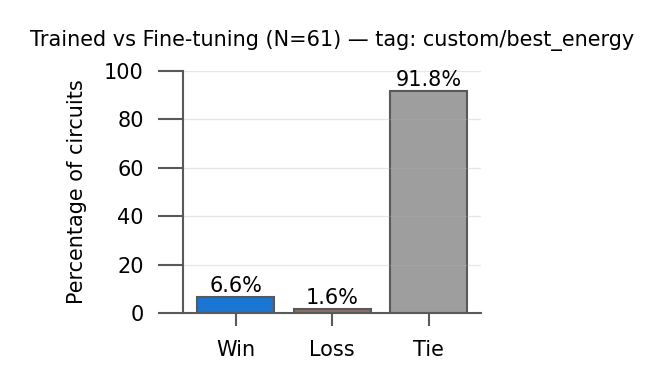

In [3]:
# ---------- TRAINED (CSV) vs FINE-TUNING (TensorBoard) ----------
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Dict, List, Tuple, Optional
from tensorboard.backend.event_processing import event_accumulator

# ====== you already have these in scope ======
# hex_ids: List[str]

# ---------- unified, export-friendly style (5 pt) ----------
mpl.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 5, "axes.titlesize": 5, "axes.labelsize": 5,
    "legend.fontsize": 5, "xtick.labelsize": 5, "ytick.labelsize": 5,
    "pdf.fonttype": 42, "ps.fonttype": 42, "pdf.use14corefonts": False, "svg.fonttype": "none",
    "axes.linewidth": 0.5, "lines.linewidth": 0.5,
    "legend.frameon": False, "savefig.dpi": 300, "figure.dpi": 100,
})
EDGE_COL, EDGE_W = "#58595B", 0.5
pt_to_in = lambda pt: pt / 72.0

def _style_axes(ax, grid_y=True):
    ax.tick_params(axis="y", which="major", width=EDGE_W, length=6, color=EDGE_COL)
    ax.tick_params(axis="y", which="minor", width=EDGE_W, length=3, color=EDGE_COL)
    ax.tick_params(axis="x", which="both",  width=EDGE_W, length=3, color=EDGE_COL)
    for s in ["left", "bottom"]:
        ax.spines[s].set_linewidth(EDGE_W)
        ax.spines[s].set_color(EDGE_COL)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    if grid_y:
        ax.grid(True, axis="y", which="major", linewidth=0.3, alpha=0.3)

# ---- TB config for FINE-TUNING ----
FINETUNE_ROOT_TEMPLATE = (
    
    "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/"
    "manuscript/fine_tune/GAT_MLP_with_scalars/4000nn/initial_state_sampling_factor_0/4_inputs/50_000_steps/{HEX}/seed_1"
)
EVENT_GLOBS = ["**/events.out.tfevents.*", "**/*tfevents*"]
TB_TAG = "custom/best_energy"
ASSUME_TAG_IS_BEST = True  # True: compare final point; False: compare global min over series

# ---- Normalization ----
def _norm_hex(x: str) -> str:
    s = str(x).strip().lower()
    if not s.startswith("0x"): s = "0x" + s
    return "0x" + s[2:].upper()

# ---- TRAINED CSV discovery patterns ----
TRAINED_CSV_PATTERNS = [
    "trained_masked/*trained_episode_metrics.csv",
    "trained_masked/trajectories/*episode_metrics.csv",
    "**/*trained_episode_metrics.csv",
    "**/trajectories/*episode_metrics.csv",
    "trained_episode_metrics.csv",  # fallback at root
]

def _trained_root_for_hex(hex_id: str) -> Path:
    # Adjust to your actual trained directory layout if needed
    return Path(
        "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/"
        f"manuscript/zero-shot/mp/5120_episodes/sf4/{_norm_hex(hex_id)}/seed_1"
    )

def _finetune_root_for_hex(hex_id: str) -> Path:
    return Path(FINETUNE_ROOT_TEMPLATE.format(HEX=_norm_hex(hex_id)))

def find_trained_csv(search_root: Path) -> Optional[Path]:
    root = Path(search_root)
    for pat in TRAINED_CSV_PATTERNS:
        hits = sorted(set(p for p in root.glob(pat)))
        if hits:
            return hits[0]
    return None

def get_trained_final_best(csv_path: Path) -> Optional[float]:
    """
    For trained per-episode metrics:
      - prefers 'best_energy_so_far'
      - else uses cummin('best_energy_in_episode')
      - returns the final best value (lower is better)
    """
    try:
        df = pd.read_csv(csv_path)
        if "episode" in df.columns:
            df["episode"] = pd.to_numeric(df["episode"], errors="coerce")
            df = df.dropna(subset=["episode"]).sort_values("episode", kind="mergesort")
        if "best_energy_so_far" in df.columns and df["best_energy_so_far"].notna().any():
            s = pd.to_numeric(df["best_energy_so_far"], errors="coerce").dropna()
            if len(s) > 0: return float(s.iloc[-1])
        if "best_energy_in_episode" in df.columns and df["best_energy_in_episode"].notna().any():
            e = pd.to_numeric(df["best_energy_in_episode"], errors="coerce").dropna()
            if len(e) > 0: return float(e.cummin().iloc[-1])
    except Exception as e:
        print(f"[WARN] Failed to read trained CSV {csv_path}: {e}")
    return None

# ---- Fine-tuning TensorBoard helpers ----
def find_event_files(root: Path) -> List[Path]:
    files = []
    for pat in EVENT_GLOBS: files.extend(root.glob(pat))
    return sorted(set(files), key=lambda p: p.as_posix())

def load_tb_scalar_from_dir(run_dir: Path, tag: str) -> Tuple[np.ndarray, np.ndarray]:
    try:
        ea = event_accumulator.EventAccumulator(str(run_dir)); ea.Reload()
        if tag not in ea.Tags().get("scalars", []):
            return np.array([], dtype=int), np.array([], dtype=float)
        ev = ea.Scalars(tag)
        steps  = np.fromiter((e.step  for e in ev), dtype=int)
        values = np.fromiter((e.value for e in ev), dtype=float)
        return steps, values
    except Exception as e:
        print(f"[WARN] TB load failed in {run_dir}: {e}")
        return np.array([], dtype=int), np.array([], dtype=float)

def pick_best_from_runs(run_dirs: List[Path], tag: str, assume_best_series=True) -> Tuple[Optional[float], Optional[Path], np.ndarray, np.ndarray]:
    """Return (best_value, chosen_dir, steps, values) for the best run (lowest value)."""
    best_val, best_dir, best_steps, best_values = None, None, None, None
    for d in run_dirs:
        steps, vals = load_tb_scalar_from_dir(d, tag)
        if steps.size == 0: continue
        candidate = float(vals[-1]) if assume_best_series else float(np.nanmin(vals))
        if best_val is None or candidate < best_val:
            best_val, best_dir, best_steps, best_values = candidate, d, steps, vals
    return best_val, best_dir, best_steps, best_values

# ======== Plot helper (compact bar) ========
def _bar_figure_compact(categories: List[str], values: List[float], title: str) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(pt_to_in(110), pt_to_in(90)), dpi=300)
    bars = ax.bar(categories, values, color=["#1976D2", "#8D6E63", "#9E9E9E"],
                  edgecolor=EDGE_COL, linewidth=EDGE_W)
    ax.set_ylim(0, 100)
    ax.set_ylabel("Percentage of circuits")
    ax.set_title(title)
    for i, v in enumerate(values):
        ax.text(i, min(100, v) + 0.5, f"{v:.1f}%", ha="center", va="bottom")
    _style_axes(ax, grid_y=True)
    fig.tight_layout()
    return fig

def _to_percentages(counts: Dict[str, int], denom: int) -> List[float]:
    if denom == 0: return [0.0, 0.0, 0.0]
    return [100.0*counts["Win"]/denom, 100.0*counts["Loss"]/denom, 100.0*counts["Tie"]/denom]

# ======== Core comparison: TRAINED vs FINE-TUNING ========
def compare_trained_to_finetune(
    hex_ids: List[str],
    tb_tag: str = TB_TAG,
    assume_tag_is_best: bool = ASSUME_TAG_IS_BEST,
    return_rows: bool = True,
):
    """
    Compare the final best energies between:
      - TRAINED: per-episode CSV (best_energy_so_far or cummin(best_energy_in_episode))
      - FINETUNE: TensorBoard scalar series (tag)
    Lower is better. 'Win' means TRAINED < FINETUNE.
    """
    outcomes = {"Win": 0, "Loss": 0, "Tie": 0}  # Win = TRAINED better
    missing, rows = [], []
    trained_hex, finetune_hex, tie_hex = [], [], []

    for hex_id in hex_ids:
        hex_norm = _norm_hex(hex_id)

        # TRAINED (CSV)
        tr_root = _trained_root_for_hex(hex_norm)
        tr_csv = find_trained_csv(tr_root)
        tr_final = get_trained_final_best(tr_csv) if tr_csv else None

        # FINETUNE (TensorBoard)
        ft_root = _finetune_root_for_hex(hex_norm)
        ft_events = find_event_files(ft_root)
        ft_run_dirs = sorted(set(p.parent for p in ft_events))
        ft_best, ft_dir, ft_steps, ft_vals = pick_best_from_runs(ft_run_dirs, tb_tag, assume_tag_is_best)

        if tr_final is None or ft_best is None:
            missing.append(hex_norm)
            continue

        if tr_final < ft_best:
            outcomes["Win"] += 1; verdict = "Win";  trained_hex.append(hex_norm)
        elif tr_final > ft_best:
            outcomes["Loss"] += 1; verdict = "Loss"; finetune_hex.append(hex_norm)
        else:
            outcomes["Tie"] += 1; verdict = "Tie";  tie_hex.append(hex_norm)

        if return_rows:
            rows.append({
                "hex_id": hex_norm,
                "trained_final": float(tr_final),
                "finetune_best": float(ft_best),
                "delta_trained_minus_finetune": float(tr_final - ft_best),
                "result": verdict,
                "trained_csv": str(tr_csv) if tr_csv else "",
                "finetune_chosen_run_dir": str(ft_dir) if ft_dir else "",
            })

    n_used = len(rows)
    if n_used == 0:
        win_pct = loss_pct = tie_pct = 0.0
    else:
        win_pct, loss_pct, tie_pct = _to_percentages(outcomes, n_used)

    # Pretty console summary
    print(f"[Trained vs Fine-tuning] counts: {outcomes} out of N={n_used} (missing {len(missing)})")
    if trained_hex:
        print(f"  Trained better ({len(trained_hex)}): {', '.join(sorted(trained_hex))}")
    if finetune_hex:
        print(f"  Fine-tuning better ({len(finetune_hex)}): {', '.join(sorted(finetune_hex))}")
    if tie_hex:
        print(f"  Ties ({len(tie_hex)}): {', '.join(sorted(tie_hex))}")
    if missing:
        print(f"  Missing ({len(missing)}): {', '.join(sorted(missing))}")

    per_hex_df = pd.DataFrame(rows)
    summary_df = pd.DataFrame([{
        "method": "trained_vs_finetune",
        "label": "Trained policy vs Fine-tuning",
        "N_used": n_used,
        "Win": outcomes["Win"], "Loss": outcomes["Loss"], "Tie": outcomes["Tie"],
        "Win_%": win_pct, "Loss_%": loss_pct, "Tie_%": tie_pct,
        "N_missing": len(missing),
        "Missing_hex_ids": ",".join(sorted(missing)),
        "Trained_better_hex_ids": ",".join(sorted(trained_hex)),
        "Finetune_better_hex_ids": ",".join(sorted(finetune_hex)),
        "Tie_hex_ids": ",".join(sorted(tie_hex)),
        "tb_tag": tb_tag,
        "assume_tag_is_best": assume_tag_is_best,
    }])

    return summary_df, per_hex_df

# ======== Orchestrator (TRAINED vs FINE-TUNING) ========
def summarize_and_plot_trained_vs_finetune(
    hex_ids: List[str],
    tb_tag: str = TB_TAG,
    assume_tag_is_best: bool = ASSUME_TAG_IS_BEST,
    make_plots: bool = True,
    show_plots: bool = False,
    save_summary_csv: Optional[Path] = None,
    save_plot_path: Optional[Path] = None,
):
    """
    Returns (summary_df, per_hex_df, fig_or_None)
    """
    cats = ["Win", "Loss", "Tie"]
    summary, per_hex = compare_trained_to_finetune(hex_ids, tb_tag, assume_tag_is_best, return_rows=True)
    win_pct, loss_pct, tie_pct = float(summary["Win_%"].iloc[0]), float(summary["Loss_%"].iloc[0]), float(summary["Tie_%"].iloc[0])

    fig = None
    if make_plots:
        title = f"Trained vs Fine-tuning (N={int(summary['N_used'].iloc[0])}) — tag: {tb_tag}"
        fig = _bar_figure_compact(cats, [win_pct, loss_pct, tie_pct], title)
        if save_plot_path is not None:
            Path(save_plot_path).parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(save_plot_path, bbox_inches="tight")
        if show_plots:
            plt.show()

    if save_summary_csv is not None:
        Path(save_summary_csv).parent.mkdir(parents=True, exist_ok=True)
        summary.to_csv(save_summary_csv, index=False)
        per_hex_out = save_summary_csv.with_name(save_summary_csv.stem + "_per_hex.csv")
        per_hex.to_csv(per_hex_out, index=False)

    return summary, per_hex, fig

# ======================== example usage ========================
# summary_df, per_hex_df, fig = summarize_and_plot_trained_vs_finetune(
#     hex_ids,
#     tb_tag="custom/best_energy",   # or your desired TB scalar tag
#     assume_tag_is_best=True,       # True: compare last point; False: compare global min
#     make_plots=True,
#     show_plots=True,
#     # save_summary_csv=Path("./trained_vs_finetune_summary.csv"),
#     # save_plot_path=Path("./trained_vs_finetune.png"),
# )


# ======================== example usage ========================
summary_df, per_hex_df, fig = summarize_and_plot_trained_vs_finetune(
    hex_ids,
    tb_tag="custom/best_energy",   # or your desired TB scalar tag
    assume_tag_is_best=True,       # True: compare last point; False: compare global min
    make_plots=True,
    show_plots=True,
    # save_summary_csv=Path("./trained_vs_finetune_summary.csv"),
    # save_plot_path=Path("./trained_vs_finetune.png"),
)


Zero shot (50,000) and scratch (50,000)

[Trained vs Scratch] counts: {'Win': 12, 'Loss': 2, 'Tie': 47} out of N=61 (missing 0)
  Trained better (12): 0x0F42, 0x1048, 0x10C9, 0x240F, 0x35C3, 0x4724, 0x4A32, 0xA2DA, 0xB8AD, 0xC4B2, 0xD326, 0xDA80
  Scratch better (2): 0xA960, 0xBC16
  Ties (47): 0x0239, 0x040B, 0x0575, 0x0643, 0x0760, 0x09AF, 0x1284, 0x1714, 0x1858, 0x1AC6, 0x22C6, 0x23A7, 0x2A38, 0x2A56, 0x2FC7, 0x3060, 0x3812, 0x3B68, 0x409B, 0x41B2, 0x429B, 0x48C1, 0x4BF8, 0x53AF, 0x53D7, 0x5B30, 0x5DA9, 0x5F01, 0x616A, 0x850E, 0x8F63, 0x93AC, 0x9591, 0x96F7, 0x9BF5, 0xA7B2, 0xB744, 0xBCA3, 0xBDF1, 0xBF36, 0xC248, 0xC766, 0xCBD6, 0xCE97, 0xE605, 0xF43F, 0xF5A4


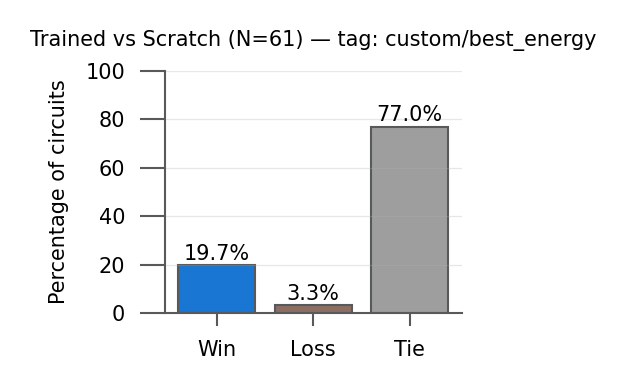

In [19]:
# ---------- TRAINED (CSV) vs TRAINED-FROM-SCRATCH (TensorBoard) ----------
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import Dict, List, Tuple, Optional
from tensorboard.backend.event_processing import event_accumulator

# ====== you already have these in scope ======
# hex_ids: List[str]

# ---------- unified, export-friendly style (5 pt) ----------
mpl.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 5, "axes.titlesize": 5, "axes.labelsize": 5,
    "legend.fontsize": 5, "xtick.labelsize": 5, "ytick.labelsize": 5,
    "pdf.fonttype": 42, "ps.fonttype": 42, "pdf.use14corefonts": False, "svg.fonttype": "none",
    "axes.linewidth": 0.5, "lines.linewidth": 0.5,
    "legend.frameon": False, "savefig.dpi": 300, "figure.dpi": 100,
})
EDGE_COL, EDGE_W = "#58595B", 0.5
pt_to_in = lambda pt: pt / 72.0

def _style_axes(ax, grid_y=True):
    ax.tick_params(axis="y", which="major", width=EDGE_W, length=6, color=EDGE_COL)
    ax.tick_params(axis="y", which="minor", width=EDGE_W, length=3, color=EDGE_COL)
    ax.tick_params(axis="x", which="both",  width=EDGE_W, length=3, color=EDGE_COL)
    for s in ["left", "bottom"]:
        ax.spines[s].set_linewidth(EDGE_W)
        ax.spines[s].set_color(EDGE_COL)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    if grid_y:
        ax.grid(True, axis="y", which="major", linewidth=0.3, alpha=0.3)

# ---- TB config for SCRATCH (TensorBoard) ----
SCRATCH_ROOT_TEMPLATE = (
    "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/"
    "manuscript/scratch_training/4in/{HEX}/seed_1"
)
EVENT_GLOBS = ["**/events.out.tfevents.*", "**/*tfevents*"]
TB_TAG = "custom/best_energy"
ASSUME_TAG_IS_BEST = True  # True: compare final point; False: compare global min over series

# ---- Normalization ----
def _norm_hex(x: str) -> str:
    s = str(x).strip().lower()
    if not s.startswith("0x"): s = "0x" + s
    return "0x" + s[2:].upper()

# ---- TRAINED CSV discovery patterns ----
TRAINED_CSV_PATTERNS = [
    "trained_masked/*trained_episode_metrics.csv",
    "trained_masked/trajectories/*episode_metrics.csv",
    "**/*trained_episode_metrics.csv",
    "**/trajectories/*episode_metrics.csv",
    "trained_episode_metrics.csv",  # fallback at root
]

def _trained_root_for_hex(hex_id: str) -> Path:
    # Adjust to your actual trained directory layout if needed
    return Path(
        "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/"
        f"manuscript/zero-shot/mp/5120_episodes/sf4/{_norm_hex(hex_id)}/seed_1"
    )

def _scratch_root_for_hex(hex_id: str) -> Path:
    return Path(SCRATCH_ROOT_TEMPLATE.format(HEX=_norm_hex(hex_id)))

def find_trained_csv(search_root: Path) -> Optional[Path]:
    root = Path(search_root)
    for pat in TRAINED_CSV_PATTERNS:
        hits = sorted(set(p for p in root.glob(pat)))
        if hits:
            return hits[0]
    return None

def get_trained_final_best(csv_path: Path) -> Optional[float]:
    """
    For trained per-episode metrics:
      - prefers 'best_energy_so_far'
      - else uses cummin('best_energy_in_episode')
      - returns the final best value (lower is better)
    """
    try:
        df = pd.read_csv(csv_path)
        if "episode" in df.columns:
            df["episode"] = pd.to_numeric(df["episode"], errors="coerce")
            df = df.dropna(subset=["episode"]).sort_values("episode", kind="mergesort")
        if "best_energy_so_far" in df.columns and df["best_energy_so_far"].notna().any():
            s = pd.to_numeric(df["best_energy_so_far"], errors="coerce").dropna()
            if len(s) > 0: return float(s.iloc[-1])
        if "best_energy_in_episode" in df.columns and df["best_energy_in_episode"].notna().any():
            e = pd.to_numeric(df["best_energy_in_episode"], errors="coerce").dropna()
            if len(e) > 0: return float(e.cummin().iloc[-1])
    except Exception as e:
        print(f"[WARN] Failed to read trained CSV {csv_path}: {e}")
    return None

# ---- Scratch (TensorBoard) helpers ----
def find_event_files(root: Path) -> List[Path]:
    files = []
    for pat in EVENT_GLOBS: files.extend(root.glob(pat))
    return sorted(set(files), key=lambda p: p.as_posix())

def load_tb_scalar_from_dir(run_dir: Path, tag: str) -> Tuple[np.ndarray, np.ndarray]:
    try:
        ea = event_accumulator.EventAccumulator(str(run_dir)); ea.Reload()
        if tag not in ea.Tags().get("scalars", []):
            return np.array([], dtype=int), np.array([], dtype=float)
        ev = ea.Scalars(tag)
        steps  = np.fromiter((e.step  for e in ev), dtype=int)
        values = np.fromiter((e.value for e in ev), dtype=float)
        return steps, values
    except Exception as e:
        print(f"[WARN] TB load failed in {run_dir}: {e}")
        return np.array([], dtype=int), np.array([], dtype=float)

def pick_best_from_runs(run_dirs: List[Path], tag: str, assume_best_series=True) -> Tuple[Optional[float], Optional[Path], np.ndarray, np.ndarray]:
    """Return (best_value, chosen_dir, steps, values) for the best run (lowest value)."""
    best_val, best_dir, best_steps, best_values = None, None, None, None
    for d in run_dirs:
        steps, vals = load_tb_scalar_from_dir(d, tag)
        if steps.size == 0: continue
        candidate = float(vals[-1]) if assume_best_series else float(np.nanmin(vals))
        if best_val is None or candidate < best_val:
            best_val, best_dir, best_steps, best_values = candidate, d, steps, vals
    return best_val, best_dir, best_steps, best_values

# ======== Plot helper (compact bar) ========
def _bar_figure_compact(categories: List[str], values: List[float], title: str) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(pt_to_in(110), pt_to_in(90)), dpi=300)
    bars = ax.bar(categories, values, color=["#1976D2", "#8D6E63", "#9E9E9E"],
                  edgecolor=EDGE_COL, linewidth=EDGE_W)
    ax.set_ylim(0, 100)
    ax.set_ylabel("Percentage of circuits")
    ax.set_title(title)
    for i, v in enumerate(values):
        ax.text(i, min(100, v) + 0.5, f"{v:.1f}%", ha="center", va="bottom")
    _style_axes(ax, grid_y=True)
    fig.tight_layout()
    return fig

def _to_percentages(counts: Dict[str, int], denom: int) -> List[float]:
    if denom == 0: return [0.0, 0.0, 0.0]
    return [100.0*counts["Win"]/denom, 100.0*counts["Loss"]/denom, 100.0*counts["Tie"]/denom]

# ======== Core comparison: TRAINED vs SCRATCH ========
def compare_trained_to_scratch(
    hex_ids: List[str],
    tb_tag: str = TB_TAG,
    assume_tag_is_best: bool = ASSUME_TAG_IS_BEST,
    return_rows: bool = True,
):
    """
    Compare the final best energies between:
      - TRAINED: per-episode CSV (best_energy_so_far or cummin(best_energy_in_episode))
      - SCRATCH: TensorBoard scalar series (tag)
    Lower is better. 'Win' means TRAINED < SCRATCH.
    """
    outcomes = {"Win": 0, "Loss": 0, "Tie": 0}  # Win = TRAINED better
    missing, rows = [], []
    trained_hex, scratch_hex, tie_hex = [], [], []

    for hex_id in hex_ids:
        hex_norm = _norm_hex(hex_id)

        # TRAINED (CSV)
        tr_root = _trained_root_for_hex(hex_norm)
        tr_csv = find_trained_csv(tr_root)
        tr_final = get_trained_final_best(tr_csv) if tr_csv else None

        # SCRATCH (TensorBoard)
        sc_root = _scratch_root_for_hex(hex_norm)
        sc_events = find_event_files(sc_root)
        sc_run_dirs = sorted(set(p.parent for p in sc_events))
        sc_best, sc_dir, sc_steps, sc_vals = pick_best_from_runs(sc_run_dirs, tb_tag, assume_tag_is_best)

        if tr_final is None or sc_best is None:
            missing.append(hex_norm)
            continue

        if tr_final < sc_best:
            outcomes["Win"] += 1; verdict = "Win";  trained_hex.append(hex_norm)
        elif tr_final > sc_best:
            outcomes["Loss"] += 1; verdict = "Loss"; scratch_hex.append(hex_norm)
        else:
            outcomes["Tie"] += 1; verdict = "Tie";  tie_hex.append(hex_norm)

        if return_rows:
            rows.append({
                "hex_id": hex_norm,
                "trained_final": float(tr_final),
                "scratch_best": float(sc_best),
                "delta_trained_minus_scratch": float(tr_final - sc_best),
                "result": verdict,
                "trained_csv": str(tr_csv) if tr_csv else "",
                "scratch_chosen_run_dir": str(sc_dir) if sc_dir else "",
            })

    n_used = len(rows)
    if n_used == 0:
        win_pct = loss_pct = tie_pct = 0.0
    else:
        win_pct, loss_pct, tie_pct = _to_percentages(outcomes, n_used)

    # Pretty console summary
    print(f"[Trained vs Scratch] counts: {outcomes} out of N={n_used} (missing {len(missing)})")
    if trained_hex:
        print(f"  Trained better ({len(trained_hex)}): {', '.join(sorted(trained_hex))}")
    if scratch_hex:
        print(f"  Scratch better ({len(scratch_hex)}): {', '.join(sorted(scratch_hex))}")
    if tie_hex:
        print(f"  Ties ({len(tie_hex)}): {', '.join(sorted(tie_hex))}")
    if missing:
        print(f"  Missing ({len(missing)}): {', '.join(sorted(missing))}")

    per_hex_df = pd.DataFrame(rows)
    summary_df = pd.DataFrame([{
        "method": "trained_vs_scratch",
        "label": "Trained policy vs Trained-from-Scratch",
        "N_used": n_used,
        "Win": outcomes["Win"], "Loss": outcomes["Loss"], "Tie": outcomes["Tie"],
        "Win_%": win_pct, "Loss_%": loss_pct, "Tie_%": tie_pct,
        "N_missing": len(missing),
        "Missing_hex_ids": ",".join(sorted(missing)),
        "Trained_better_hex_ids": ",".join(sorted(trained_hex)),
        "Scratch_better_hex_ids": ",".join(sorted(scratch_hex)),
        "Tie_hex_ids": ",".join(sorted(tie_hex)),
        "tb_tag": tb_tag,
        "assume_tag_is_best": assume_tag_is_best,
    }])

    return summary_df, per_hex_df

# ======== Orchestrator (TRAINED vs SCRATCH) ========
def summarize_and_plot_trained_vs_scratch(
    hex_ids: List[str],
    tb_tag: str = TB_TAG,
    assume_tag_is_best: bool = ASSUME_TAG_IS_BEST,
    make_plots: bool = True,
    show_plots: bool = False,
    save_summary_csv: Optional[Path] = None,
    save_plot_path: Optional[Path] = None,
):
    """
    Returns (summary_df, per_hex_df, fig_or_None)
    """
    cats = ["Win", "Loss", "Tie"]
    summary, per_hex = compare_trained_to_scratch(hex_ids, tb_tag, assume_tag_is_best, return_rows=True)
    win_pct, loss_pct, tie_pct = float(summary["Win_%"].iloc[0]), float(summary["Loss_%"].iloc[0]), float(summary["Tie_%"].iloc[0])

    fig = None
    if make_plots:
        title = f"Trained vs Scratch (N={int(summary['N_used'].iloc[0])}) — tag: {tb_tag}"
        fig = _bar_figure_compact(cats, [win_pct, loss_pct, tie_pct], title)
        if save_plot_path is not None:
            Path(save_plot_path).parent.mkdir(parents=True, exist_ok=True)
            fig.savefig(save_plot_path, bbox_inches="tight")
        if show_plots:
            plt.show()

    if save_summary_csv is not None:
        Path(save_summary_csv).parent.mkdir(parents=True, exist_ok=True)
        summary.to_csv(save_summary_csv, index=False)
        per_hex_out = save_summary_csv.with_name(save_summary_csv.stem + "_per_hex.csv")
        per_hex.to_csv(per_hex_out, index=False)

    return summary, per_hex, fig

# ======================== example usage ========================
# summary_df, per_hex_df, fig = summarize_and_plot_trained_vs_scratch(
#     hex_ids,
#     tb_tag="custom/best_energy",   # or your desired TB scalar tag
#     assume_tag_is_best=True,       # True: compare last point; False: compare global min
#     make_plots=True,
#     show_plots=True,
#     # save_summary_csv=Path("./trained_vs_scratch_summary.csv"),
#     # save_plot_path=Path("./trained_vs_scratch.png"),
# )

# ======================== example usage (active) ========================
summary_df, per_hex_df, fig = summarize_and_plot_trained_vs_scratch(
    hex_ids,
    tb_tag="custom/best_energy",   # or your desired TB scalar tag
    assume_tag_is_best=True,       # True: compare last point; False: compare global min
    make_plots=True,
    show_plots=True,
    # save_summary_csv=Path("./trained_vs_scratch_summary.csv"),
    # save_plot_path=Path("./trained_vs_scratch.png"),
)


[Trained vs Scratch] counts: {'Win': 12, 'Loss': 2, 'Tie': 47} out of N=61 (missing 0)
  Trained better (12): 0x0F42, 0x1048, 0x10C9, 0x240F, 0x35C3, 0x4724, 0x4A32, 0xA2DA, 0xB8AD, 0xC4B2, 0xD326, 0xDA80
  Scratch better (2): 0xA960, 0xBC16
  Ties (47): 0x0239, 0x040B, 0x0575, 0x0643, 0x0760, 0x09AF, 0x1284, 0x1714, 0x1858, 0x1AC6, 0x22C6, 0x23A7, 0x2A38, 0x2A56, 0x2FC7, 0x3060, 0x3812, 0x3B68, 0x409B, 0x41B2, 0x429B, 0x48C1, 0x4BF8, 0x53AF, 0x53D7, 0x5B30, 0x5DA9, 0x5F01, 0x616A, 0x850E, 0x8F63, 0x93AC, 0x9591, 0x96F7, 0x9BF5, 0xA7B2, 0xB744, 0xBCA3, 0xBDF1, 0xBF36, 0xC248, 0xC766, 0xCBD6, 0xCE97, 0xE605, 0xF43F, 0xF5A4


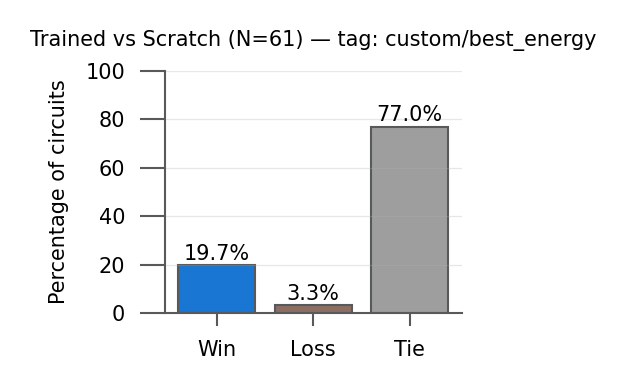

In [20]:
folder = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/plots/zeroshot_vs_scratch_50000_quality_sf4"
base = Path(folder)  # turn the string into a Path

summary_df, per_hex_df, fig = summarize_and_plot_trained_vs_scratch(
    hex_ids=hex_ids,                  # list of "0x.." ids
    tb_tag="custom/best_energy",
    assume_tag_is_best=True,          # True: use final; False: global min
    make_plots=True,
    show_plots=True,
    save_plot_path= base / "zeroshot_vs_scratch.svg",
    save_summary_csv = base / "zeroshot_vs_scratch_summary.csv",
)

Updated

In [27]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pathlib import Path
import matplotlib.ticker as ticker
from typing import Dict, List, Tuple, Optional

mpl.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 5, "axes.titlesize": 5, "axes.labelsize": 5,
    "legend.fontsize": 5, "xtick.labelsize": 5, "ytick.labelsize": 5,
    "pdf.fonttype": 42, "ps.fonttype": 42,
    "pdf.use14corefonts": False, "svg.fonttype": "none",
    "axes.linewidth": 0.5, "lines.linewidth": 0.5,
    "legend.frameon": False,
    "savefig.dpi": 300, "figure.dpi": 300,
})
EDGE_COL, EDGE_W = "#58595B", 0.5
pt_to_in = lambda pt: pt / 72.0

def _style_axes(ax, grid_y=True):
    # ticks
    ax.tick_params(axis="y", which="major", width=EDGE_W, length=6, color=EDGE_COL)
    ax.tick_params(axis="y", which="minor", width=EDGE_W, length=3, color=EDGE_COL)
    ax.tick_params(axis="x", which="both",  width=EDGE_W, length=3, color=EDGE_COL)
    # spines
    for s in ["left", "bottom"]:
        ax.spines[s].set_linewidth(EDGE_W)
        ax.spines[s].set_color(EDGE_COL)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    # grid
    if grid_y:
        ax.grid(True, axis="y", which="major", linewidth=0.3, alpha=0.3)

def _norm_hex(x: str) -> str:
    s = str(x).strip().lower()
    if not s.startswith("0x"):
        s = "0x" + s
    return "0x" + s[2:].upper()

def smooth(vals, weight=0.0):
    out, last = [], vals[0] if len(vals) else 0
    for v in vals:
        last = last * weight + (1 - weight) * v
        out.append(last)
    return np.asarray(out)

def load_curve(run_dir: Path, tag="custom/best_energy", zero_at_start=True) -> Tuple[np.ndarray, np.ndarray]:
    try:
        ea = event_accumulator.EventAccumulator(str(run_dir))
        ea.Reload()
        events = ea.Scalars(tag)
        steps  = np.fromiter((e.step  for e in events), dtype=int)
        values = np.fromiter((e.value for e in events), dtype=float)
        if zero_at_start and len(steps) and steps[0] != 0:
            steps = steps - steps[0]   # normalize X to start at 0
        return steps, values
    except Exception as e:
        print(f"[warn] TB load failed in {run_dir}: {e}")
        return np.array([], dtype=int), np.array([], dtype=float)

def load_track1_csv(csv_path: Path, use_wall_time=False, zero_at_start=True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Expected columns (header order not strictly required): Step,custom/best_energy,wall_time_s
    X = Step (int) or wall_time_s (float), Y = custom/best_energy (float)
    """
    if not csv_path.exists():
        print(f"[warn] Track 1 CSV not found: {csv_path}")
        return np.array([]), np.array([])
    xs, ys = [], []
    with csv_path.open("r") as f:
        header = [h.strip() for h in f.readline().split(",")]
        # allow flexible column order
        try:
            step_idx      = header.index("Step")
            best_idx      = header.index("custom/best_energy")
            wall_time_idx = header.index("wall_time_s")
        except ValueError:
            # fall back to fixed positions (Step, custom/best_energy, wall_time_s)
            step_idx, best_idx, wall_time_idx = 0, 1, 2

        for line in f:
            parts = [p.strip() for p in line.split(",")]
            if len(parts) <= max(step_idx, best_idx, wall_time_idx):
                continue

            # pick X
            if use_wall_time:
                try:
                    x = float(parts[wall_time_idx]) if parts[wall_time_idx] != "" else None
                except ValueError:
                    x = None
            else:
                try:
                    x = int(parts[step_idx])
                except ValueError:
                    x = None

            # Y = best energy
            try:
                y = float(parts[best_idx]) if parts[best_idx] != "" else None
            except ValueError:
                y = None

            if x is not None and y is not None:
                xs.append(x); ys.append(y)

    xs = np.asarray(xs, dtype=float if use_wall_time else int)
    ys = np.asarray(ys, dtype=float)
    if zero_at_start and len(xs):
        xs = xs - xs[0]
    return xs, ys

# ── Paths & colors (as requested) ────────────────────────────────────────────
def ft_path(circuit_hex: str) -> Path:
    return Path(
        f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/"
        f"manuscript/fine_tune/GAT_MLP_with_scalars/4000nn/initial_state_sampling_factor_0/4_inputs/50_000_steps/{circuit_hex}/seed_1"
    )

def scratch_path(circuit_hex: str) -> Path:
    return Path(
        f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/"
        f"manuscript/scratch_training/4in/{circuit_hex}/seed_1"
    )

def zeroshot_csv_path(circuit_hex: str) -> Path:
    # Track 1 CSV with sf4, as in your example
    return Path(
        f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/"
        f"manuscript/zero-shot/mp/5120_episodes/sf0/{circuit_hex}/seed_1/trained_masked/tb_compat_steps.csv"
    )

COLORS = {
    "Pre-trained fine-tune": "#FF914D",
    "Scratch":               "#417FF1",
    "Zero-shot":             "#2CB67D",
}

# ── Per-circuit plot ─────────────────────────────────────────────────────────
def plot_circuit_comparison(
    circuit_hex: str,
    out_dir: Path,
    use_wall_time_for_zeroshot: bool = False,
    smooth_weight: float = 0.0,
    yscale_log: bool = True,
    tag: str = "custom/best_energy",
    figsize_pt: Tuple[int, int] = (130, 110),
) -> Optional[Path]:
    circuit = _norm_hex(circuit_hex)
    out_dir.mkdir(parents=True, exist_ok=True)

    run_dirs = {
        "Pre-trained fine-tune": ft_path(circuit),
        "Scratch":               scratch_path(circuit),
    }
    track1_files = {
        "Zero-shot": zeroshot_csv_path(circuit),
    }

    # Load
    data = {}
    for label, p in run_dirs.items():
        steps, vals = load_curve(p, tag=tag, zero_at_start=True)
        data[label] = (steps, vals)

    for label, p in track1_files.items():
        xs, ys = load_track1_csv(p, use_wall_time=use_wall_time_for_zeroshot, zero_at_start=True)
        data[label] = (xs, ys)

    if all(len(v[0]) == 0 for v in data.values()):
        print(f"[info] No data found for {circuit}")
        return None

    # Figure — match earlier sizing + dpi
    fig, ax = plt.subplots(figsize=(pt_to_in(figsize_pt[0]), pt_to_in(figsize_pt[1])), dpi=300)

    # Plot each curve (lw and linestyle like before; keep your colors)
    for label, (xs, ys) in data.items():
        if len(xs) == 0:
            print(f"[warn] no data for {label} — {circuit}")
            continue
        ax.plot(
            xs,
            smooth(ys, weight=smooth_weight),
            lw=1.0,
            label=label,
            color=COLORS.get(label, None),
            linestyle="--" if label == "Zero-shot" else "-"
        )

    # Axes, labels, scale, formatters
    if yscale_log:
        ax.set_yscale("log")
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y:.0f}"))

    x_label = "Wall time (s)" if use_wall_time_for_zeroshot else "Steps"
    ax.set_xlabel(x_label)
    ax.set_ylabel("Metric (lower is better)")  # same wording as earlier code

    # Apply shared styling (ticks, spines, grid)
    _style_axes(ax, grid_y=True)

    # Legend and title match
    ax.legend(frameon=False)
    ax.set_title(f"{circuit}")

    fig.tight_layout()
    out_path = out_dir / f"{circuit}.png"
    fig.savefig(out_path, bbox_inches="tight")
    plt.close(fig)
    return out_path

# ── Orchestrator for all hex IDs ─────────────────────────────────────────────
def plot_all_circuits(
    hex_ids: List[str],
    output_root: Path = Path("./per_circuit_plots"),
    use_wall_time_for_zeroshot: bool = False,
    smooth_weight: float = 0.0,
    yscale_log: bool = True,
    tag: str = "custom/best_energy",
    figsize_pt: Tuple[int, int] = (100, 100),
) -> Dict[str, Optional[Path]]:
    output_root.mkdir(parents=True, exist_ok=True)
    results = {}
    for h in hex_ids:
        p = plot_circuit_comparison(
            h, output_root,
            use_wall_time_for_zeroshot=use_wall_time_for_zeroshot,
            smooth_weight=smooth_weight,
            yscale_log=yscale_log,
            tag=tag,
            figsize_pt=figsize_pt,
        )
        results[_norm_hex(h)] = p
    # Quick summary
    done = sum(1 for v in results.values() if v is not None)
    skipped = len(results) - done
    print(f"[summary] Plotted {done} / {len(results)} circuits (skipped {skipped} with no data).")
    return results




In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path

# ---------- helpers to compute best + steps-to-best ----------
def _first_min_step(xs: np.ndarray, ys: np.ndarray) -> float:
    """
    Given aligned xs (steps/time) and ys (metric), return the x at FIRST global minimum.
    Returns np.nan if series is empty or invalid.
    """
    if xs is None or ys is None or len(xs) == 0 or len(ys) == 0:
        return np.nan
    idx = np.nanargmin(ys)
    return float(xs[idx])

def _final_best(ys: np.ndarray) -> float:
    """Return the global minimum value in the series, or np.nan if empty."""
    if ys is None or len(ys) == 0:
        return np.nan
    return float(np.nanmin(ys))

# ---------- per-circuit metrics extractor (reuses earlier loaders) ----------
def compute_per_circuit_metrics(
    hex_ids,
    use_wall_time_for_zeroshot: bool = False,
    tag: str = "custom/best_energy",
    zero_at_start: bool = True,
):
    """
    For each circuit, load all three series and compute:
      - final_best_{method}
      - steps_to_best_{method}
    Returns a dict: {hex: {keys...}} suitable to convert into a DataFrame.
    """
    out = {}
    for h in hex_ids:
        circuit = _norm_hex(h)

        # Load series
        # TB methods
        ft_steps, ft_vals = load_curve(ft_path(circuit), tag=tag, zero_at_start=zero_at_start)
        sc_steps, sc_vals = load_curve(scratch_path(circuit), tag=tag, zero_at_start=zero_at_start)
        # Zero-shot CSV (Track 1)
        zs_steps, zs_vals = load_track1_csv(zeroshot_csv_path(circuit),
                                            use_wall_time=use_wall_time_for_zeroshot,
                                            zero_at_start=zero_at_start)

        # Compute bests and steps
        rec = {"hex_id": circuit}

        rec["final_best_ft"] = _final_best(ft_vals)
        rec["final_best_sc"] = _final_best(sc_vals)
        rec["final_best_zs"] = _final_best(zs_vals)

        rec["steps_to_best_ft"] = _first_min_step(ft_steps, ft_vals)
        rec["steps_to_best_sc"] = _first_min_step(sc_steps, sc_vals)
        rec["steps_to_best_zs"] = _first_min_step(zs_steps, zs_vals)

        out[circuit] = rec
    return out

# ---------- pair-wise tie scatter plotting ----------
def _pair_label(a: str, b: str):
    # Nice labels for plot axes
    name_map = {"ft":"Pre-trained fine-tune", "sc":"Scratch", "zs":"Zero-shot"}
    return name_map.get(a, a), name_map.get(b, b)

def plot_pairwise_tie_steps(
    hex_ids,
    use_wall_time_for_zeroshot: bool = False,
    tag: str = "custom/best_energy",
    zero_at_start: bool = True,
    pairs = (("ft","sc"), ("ft","zs"), ("sc","zs")),
    atol: float = 1e-9,
    rtol: float = 0.0,
    figsize_pt = (100, 100),
    out_dir: Path = Path("./pairwise_tie_plots"),
    save: bool = True,
    formats = ("png",),  # e.g., ("png","svg") or ("png","pdf")
):
    import pandas as pd
    out_dir.mkdir(parents=True, exist_ok=True)
    saved = {}  # { "ft_vs_sc": [Path(...), ...], ... }

    metrics = compute_per_circuit_metrics(
        hex_ids,
        use_wall_time_for_zeroshot=use_wall_time_for_zeroshot,
        tag=tag,
        zero_at_start=zero_at_start,
    )
    df = pd.DataFrame.from_dict(metrics, orient="index").reset_index(drop=True)

    key_best = {"ft": "final_best_ft", "sc": "final_best_sc", "zs": "final_best_zs"}
    key_steps = {"ft": "steps_to_best_ft", "sc": "steps_to_best_sc", "zs": "steps_to_best_zs"}

    for a, b in pairs:
        a_best, b_best = key_best[a], key_best[b]
        a_steps, b_steps = key_steps[a], key_steps[b]
        la, lb = _pair_label(a, b)

        sub = df[
            df[a_best].notna() & df[b_best].notna() &
            np.isfinite(df[a_best]) & np.isfinite(df[b_best]) &
            np.isclose(df[a_best], df[b_best], atol=atol, rtol=rtol) &
            df[a_steps].notna() & df[b_steps].notna() &
            np.isfinite(df[a_steps]) & np.isfinite(df[b_steps])
        ].copy()

        N = len(sub)
        if N == 0:
            print(f"[info] No ties for {la} vs {lb}; skipping.")
            continue

        x = sub[b_steps].astype(float).to_numpy()
        y = sub[a_steps].astype(float).to_numpy()

        fig, ax = plt.subplots(figsize=(pt_to_in(figsize_pt[0]), pt_to_in(figsize_pt[1])), dpi=300)
        ax.scatter(x, y, s=8, linewidths=0.3)

        lo = float(min(np.nanmin(x), np.nanmin(y)))
        hi = float(max(np.nanmax(x), np.nanmax(y)))
        pad = 0.02 * (hi - lo) if hi > lo else 1.0
        ax.plot([lo - pad, hi + pad], [lo - pad, hi + pad], "--")

        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel(f"{lb} — steps to best (lower is faster)")
        ax.set_ylabel(f"{la} — steps to best (lower is faster)")
        ax.set_title(f"Ties only: {la} vs {lb} — same final best size (N={N})")

        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda t,_: f"{int(t):,}"))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda t,_: f"{int(t):,}"))
        fig.tight_layout()

        # SAVE HERE
        tag_name = f"ties_{a}_vs_{b}".replace("/", "-")
        saved_paths = []
        if save:
            for ext in formats:
                out_path = out_dir / f"{tag_name}.{ext}"
                fig.savefig(out_path, bbox_inches="tight")  # uses your rcParams savefig.dpi=300
                saved_paths.append(out_path)
            print(f"[saved] {la} vs {lb} → {', '.join(map(str, saved_paths))}")

        plt.close(fig)  # important to avoid memory bloat when looping
        saved[tag_name] = saved_paths

    return df, saved

In [29]:
folder = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/plots/zero_vs_scratch_50000_quality_sf0"
base = Path(folder)

df, saved = plot_pairwise_tie_steps(
    hex_ids,
    pairs=(("ft","sc"), ("ft","zs"), ("zs","sc")),
    out_dir=base / "pairwise_tie_plots",
    formats=("png","svg"),
)

[saved] Pre-trained fine-tune vs Scratch → /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/plots/zero_vs_scratch_50000_quality_sf0/pairwise_tie_plots/ties_ft_vs_sc.png, /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/plots/zero_vs_scratch_50000_quality_sf0/pairwise_tie_plots/ties_ft_vs_sc.svg
[saved] Pre-trained fine-tune vs Zero-shot → /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/plots/zero_vs_scratch_50000_quality_sf0/pairwise_tie_plots/ties_ft_vs_zs.png, /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/plots/zero_vs_scratch_50000_quality_sf0/pairwise_tie_plots/ties_ft_vs_zs.svg
[saved] Zero-shot vs Scratch → /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/plots/zero_vs_scratch_50000_quality_sf0/pairwise_tie_plots/ties_zs_vs_sc.png

Print order for scratch 

In [ ]:
def print_optimal_order_for_scratch(
    hex_ids: List[str],
    tag: str = TB_TAG,
    assume_tag_is_best: bool = ASSUME_TAG_IS_BEST,
    ascending: bool = True,
    return_df: bool = False,
) -> Optional[pd.DataFrame]:
    """
    For each circuit (hex_id), look only at SCRATCH runs and determine:
      - the best scratch value (per `assume_tag_is_best` logic for picking a run)
      - the step at which that best value was first achieved (global min within chosen run)
    Then print circuits ordered by the step count (lower = earlier), and optionally return a DataFrame.

    Parameters
    ----------
    hex_ids : list of hex IDs (with or without '0x' prefix)
    tag : TensorBoard scalar tag (default from TB_TAG)
    assume_tag_is_best : if True, pick the run by final point; else by global min over the series
    ascending : True -> earliest first; False -> latest first
    return_df : if True, return the DataFrame with results

    Returns
    -------
    df : Optional[pd.DataFrame] with columns:
         ['hex_id','scratch_best','scratch_steps_to_best','scratch_chosen_run_dir','has_data']
    """
    rows = []
    missing = []

    for hex_id in hex_ids:
        hex_norm = _norm_hex(hex_id)

        sc_root = scratch_root_for_hex(hex_norm)
        sc_events = find_event_files(sc_root)
        sc_run_dirs = sorted(set(p.parent for p in sc_events))
        sc_best, sc_dir, sc_steps, sc_vals = pick_best_from_runs(sc_run_dirs, tag, assume_tag_is_best)

        if sc_best is None or sc_steps is None or sc_vals is None or len(sc_steps) == 0:
            missing.append(hex_norm)
            rows.append({
                "hex_id": hex_norm,
                "scratch_best": np.nan,
                "scratch_steps_to_best": np.nan,
                "scratch_chosen_run_dir": "",
                "has_data": False,
            })
            continue

        step_to_best = _steps_to_global_min(sc_steps, sc_vals)

        rows.append({
            "hex_id": hex_norm,
            "scratch_best": float(sc_best),
            "scratch_steps_to_best": float(step_to_best),
            "scratch_chosen_run_dir": str(sc_dir) if sc_dir else "",
            "has_data": True,
        })

    df = pd.DataFrame(rows)

    # Sort with NaNs at the end, secondary by hex_id for deterministic order
    df["_sort_steps"] = df["scratch_steps_to_best"].fillna(np.inf)
    df = df.sort_values(by=["_sort_steps", "hex_id"], ascending=[ascending, True]).drop(columns=["_sort_steps"])

    # Pretty print
    print("\n[Scratch-only] Order circuits by step when best was first achieved")
    rank = 1
    for _, r in df.iterrows():
        if not np.isfinite(r["scratch_steps_to_best"]):
            continue
        print(f"{rank:>3}. {r['hex_id']}: {int(r['scratch_steps_to_best'])} steps — "
              f"SC_best={r['scratch_best']:.6g}")
        rank += 1

    if missing:
        print(f"\n[Info] Missing or empty scratch data for {len(missing)} circuits:")
        print("  " + ", ".join(sorted(missing)))

    return df if return_df else None


In [9]:
SCRATCH_ROOT_TEMPLATE = (
    "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/"
    "manuscript/scratch_training/4in/{HEX}/seed_1"
)

scratch_order_df = print_optimal_order_for_scratch(
    hex_ids=hex_ids,
    tag="custom/best_energy",
    assume_tag_is_best=True,
    ascending=True,
    return_df=True,
)


[Scratch-only] Order circuits by step when best was first achieved
  1. 0x0575: 80 steps — SC_best=5
  2. 0xF5A4: 80 steps — SC_best=7
  3. 0x23A7: 160 steps — SC_best=7
  4. 0x5B30: 160 steps — SC_best=11
  5. 0x8F63: 160 steps — SC_best=12
  6. 0x5F01: 240 steps — SC_best=8
  7. 0xD326: 240 steps — SC_best=15
  8. 0xF43F: 240 steps — SC_best=6
  9. 0x4A32: 320 steps — SC_best=10
 10. 0x040B: 400 steps — SC_best=8
 11. 0x1858: 400 steps — SC_best=6
 12. 0xB744: 560 steps — SC_best=8
 13. 0x3060: 880 steps — SC_best=8
 14. 0x10C9: 1040 steps — SC_best=13
 15. 0xA2DA: 1200 steps — SC_best=12
 16. 0xBF36: 1360 steps — SC_best=11
 17. 0xBDF1: 1440 steps — SC_best=9
 18. 0x1714: 1520 steps — SC_best=9
 19. 0x96F7: 1520 steps — SC_best=10
 20. 0x0239: 1600 steps — SC_best=11
 21. 0x616A: 1600 steps — SC_best=10
 22. 0x850E: 1600 steps — SC_best=11
 23. 0xC248: 1600 steps — SC_best=11
 24. 0x48C1: 1680 steps — SC_best=12
 25. 0x9591: 2000 steps — SC_best=6
 26. 0x41B2: 2080 steps — SC_best=